### Purpose of Notebook

Visualize material property models.


In [25]:
from matplotlib import pyplot as plt
import numpy as np
import warnings
from typing import List, Tuple
import sys
sys.path.append("../")
from matplotlib import rc
import pickle
from matplotlib.lines import Line2D

#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
from common_util import setup_axis_default,setup_plotting_format,ProjectPaths,NogamiUEData, NogamiTEData,NogamiUTSData,NogamiConductivityData
setup_plotting_format()
paths = ProjectPaths()
MODEL_PATH = paths.MODEL

#load data
class ModifiedNogamiUEData(NogamiUEData):

    def __init__(self,threshold: float):
        super().__init__()
        self.threshold = threshold

    def __getitem__(self, key: str) -> Tuple[np.ndarray]:
        x,y  = super().__getitem__(key)
        index = x.squeeze() > self.threshold
        return x[index],y[index]
    
#load data
class ModifiedNogamiTEData(NogamiTEData):

    def __init__(self,threshold: float):
        super().__init__()
        self.threshold = threshold

    def __getitem__(self, key: str) -> Tuple[np.ndarray]:
        x,y  = super().__getitem__(key)
        index = np.all(np.array([x.squeeze() > self.threshold,
                                 x.squeeze() < 1200]).T,axis = 1)
        return x[index],y[index]

class ModifedNogamiConductivityData(NogamiConductivityData):

    _lookup = {'W Plate (H)': 'Pure W (H) Plate',
               'K-W3%Re Plate (H)': 'K-doped W-3%Re (H) Plate',
               'K-W3%Re Plate (L)': 'K-doped W-3%Re (H) Plate'}
    
    def __getitem__(self, key):
        return super().__getitem__(self._lookup[key])

nogami_te_data = ModifiedNogamiTEData(threshold = 200)
nogami_ue_data = ModifiedNogamiUEData(threshold = 150)
nogami_uts_data = NogamiUTSData()
nogami_conductivity_data = ModifedNogamiConductivityData()


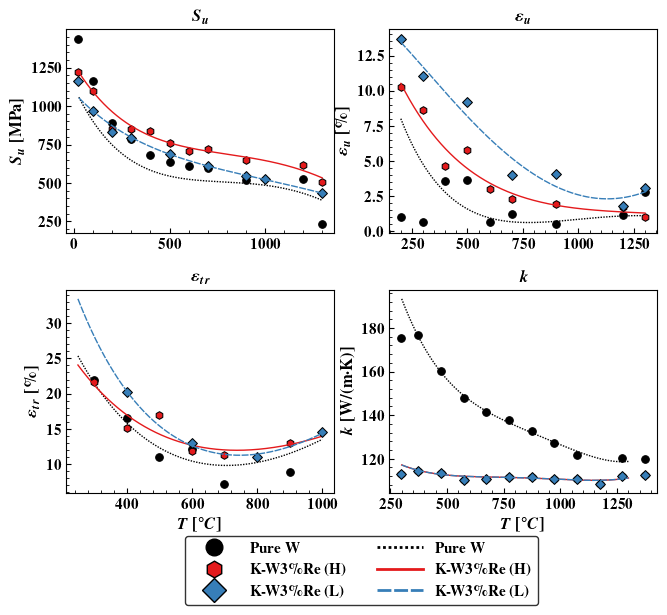

In [30]:
fig,axes_ = plt.subplot_mosaic("""AB
                                CD
                                EE""",figsize = (6.5,6),
                                height_ratios= [1,1,0.2])

axes = np.array([axes_[key] for key in ['A','B','C','D']]).reshape(2,2)
lax = axes_['E']
materials = ['W Plate (H)','K-W3%Re Plate (H)','K-W3%Re Plate (L)'] 
titles = [r'$S_u$',r'$\varepsilon_{u}$',r'$\varepsilon_{tr}$',r'$k$']
units = [r'[MPa]',r'[\%]',r'[\%]',r'[W/(m$\cdot$K)]']
properties = ['uts','ue','te','k']
labels = [r'\textbf{Pure W}',r'\textbf{K-W3\%Re (H)}',r'\textbf{K-W3\%Re (L)}']    
colors = ['k'] + plt.get_cmap('Set1')(np.array([0,0.2])).tolist()
ls = [(0, (1, 1)),'-',(0, (5, 1))]
markers = ['o','h','D']
sizes = [30,30,25.]
data_getters = [nogami_uts_data,nogami_ue_data,nogami_te_data,nogami_conductivity_data]

temp_mins = [25,200,250,300]
temp_maxs = [1300,1300,1000,1300]
for title,ax,property,data_getter,tmin,tmax in zip(titles,axes.flat,properties,data_getters,temp_mins,temp_maxs):
    setup_axis_default(ax)
    ax.set_title(title,fontsize = 12,fontweight = 'bold')

    for material,color,marker,style,size in zip(materials,colors,markers,ls,sizes):
        x,y = data_getter[material]
        ax.scatter(x,y,facecolor = color,edgecolor = 'k',
                   label = labels[materials.index(material)],marker = marker,s = size,
                   lw = 0.75)
        
        with open(MODEL_PATH.joinpath(material + '_' + property + '.pkl'),'rb') as f:
            model = pickle.load(f)

        x = np.linspace(tmin,tmax,1000)
        y = model.predict(x.reshape(-1,1))
        ax.plot(x,y,color = color,linestyle = style,lw = 1.0,zorder = 1)

for ax in axes[1,:]:
    ax.set_xlabel(r'$T$ \textbf{[$^\circ C$]}',fontsize = 12,fontweight = 'bold')

for ax,title,unit in zip(axes.flat,titles,units):
    ax.set_ylabel(r'\textbf{' + title + ' ' + unit + '}',fontsize = 12,fontweight = 'bold')

lax.axis('off')
legend = lax.legend(
    handles = [Line2D([0], [0], marker=marker, 
                      markerfacecolor = color,
                      lw=0,
                      markeredgecolor = 'k', 
                      markeredgewidth = 1.,
                      label=label,
                      markersize = 12) for marker,label,color in zip(markers,labels,colors)] + 
    [Line2D([0], [0], linestyle=style,
                      color = color,
                      lw=2, 
                      label= label) for style,color,label in zip(ls,colors,labels)],
    loc='center',fontsize = 11,ncols = 2,handlelength = 3.
)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)

fig.tight_layout(pad = 0.1)
fig.savefig(paths.IMAGES.joinpath('nogami_modeled_properties.svg'))